In [7]:
%matplotlib inline

# Load data

In [1]:
import dlc_bci

train_input_100 , train_target_100 = dlc_bci.load(root = './data_bci_100Hz', download = False)
test_input_100 , test_target_100 = dlc_bci.load(root = './data_bci_100Hz', download = False, train = False)

train_input_1000 , train_target_1000 = dlc_bci.load(root = './data_bci_1000Hz', download = False, one_khz = True)
test_input_1000 , test_target_1000 = dlc_bci.load(root = './data_bci_1000Hz', download = False, train = False, one_khz = True)

# Visualize data

In [2]:
print("Train input 100 Hz: {:d}x{:d}x{:d}".format(*(s for s in train_input_100.size())))
print("Train target 100 Hz: {:d}".format(*(s for s in train_target_100.size())))
print("Test input 100 Hz: {:d}x{:d}x{:d}".format(*(s for s in test_input_100.size())))
print("Test target 100 Hz: {:d}".format(*(s for s in test_target_100.size())))
print("")
print("Train input 1000 Hz: {:d}x{:d}x{:d}".format(*(s for s in train_input_1000.size())))
print("Train target 1000 Hz: {:d}".format(*(s for s in train_target_1000.size())))
print("Test input 1000 Hz: {:d}x{:d}x{:d}".format(*(s for s in test_input_1000.size())))
print("Test target 1000 Hz: {:d}".format(*(s for s in test_target_1000.size())))

Ntrain = train_input_100.size(0)
Ntest = test_input_100.size(0)
Nchannels = train_input_100.size(1)
Nsamples_100 = train_input_100.size(-1)
Nsamples_1000 = train_input_1000.size(-1)

Train input 100 Hz: 316x28x50
Train target 100 Hz: 316
Test input 100 Hz: 100x28x50
Test target 100 Hz: 100

Train input 1000 Hz: 316x28x500
Train target 1000 Hz: 316
Test input 1000 Hz: 100x28x500
Test target 1000 Hz: 100


# Nearest-neighbor classifier
See practical session 2.  

Each sample is treated as an Nchannels\*Nsamples 1D vector and simple 1-nearest-neighbor (1-NN) matching is performed for classification.  


Principal Component Analysis (PCA) with varying numbers of principal components coupled with 1-NN matching is also investigated. 


The test samples are classified one by one to avoid out-of-RAM errors.

In [3]:
import torch
from torch import Tensor
def nearest_classification(train_input, train_target, x):
    # train_input is n x d; train_target is n, x is m x d

    # Low memory option
    cross_prod = torch.mm(train_input, x.t())  # n x m
    Tsquared = train_input.pow(2).sum(dim=1, keepdim=True)  # n x 1
    Xsquared = x.pow(2).sum(dim=1, keepdim=True)  # m x 1
    _, ind_nn = (Tsquared + Xsquared.t() - 2*cross_prod).min(dim=0)  # broadcasting used here
    return train_target[ind_nn]  # returns Tensor (LongTensor if train_target is LongTensor)

def compute_nb_errors(train_input, train_target, test_input, test_target,
                      mean = None, proj = None):
    # train_input is n x d; train_target is n; test_input is m x d; test_target is n; mean is d; proj is d x c
    # Center data
    if mean is not None:
        train_input = train_input - mean
        test_input = test_input - mean
    # Apply projection
    if proj is not None:
        train_input = train_input.mm(proj).mm(proj.t())  # last multiplication is superfluous in k-NN matching
        test_input = test_input.mm(proj).mm(proj.t())  # last multiplication is superfluous in k-NN matching
    # Compute number of classification errors
    nearest_target = nearest_classification(train_input, train_target, test_input)
    return torch.sum( nearest_target != test_target)

def PCA(x):
    x_mean = x.mean(dim=0)
    x = x - x_mean
    e_vals, e_vecs = torch.eig(torch.mm(x.t(),x), eigenvectors=True)  # STRANGE: e_vals is d x 2 SOL: x.t().mm(x)
    _, sorted_indices = torch.sort(e_vals[:, 0], descending=True) 
    return (x_mean, e_vecs[:, sorted_indices]) # first output has dimension d; second output d x d

In [4]:
# Classical 1-nearest-neighbor classification
N_err_near_neigh = 0
for i in range(Ntest):  # classify test samples one by one
    N_err_near_neigh += compute_nb_errors(train_input_100.view(Ntrain,-1), train_target_100,
                                          test_input_100[i].view(1,-1), test_target_100[i])
print("Basic nearest-neighbor search in original coordinate space:"
      " test error rate {:g}%".format(100*N_err_near_neigh/Ntest))  

# Including PCA pre-processing
dim = Nchannels*Nsamples_100  # dimensionality of space in which our samples lie
cvals = [3, 10, 50, 100, 200, 500, int(dim/2)]  # number of principal components (<= dim)
Nerrs = Tensor(len(cvals)).zero_()
mean_train, PCA_basis = PCA(train_input_100.view(Ntrain,-1))
for ic in range(len(cvals)): 
    P = PCA_basis[:, :cvals[ic]]  # d x c  where d is the space dimension
    test_pred = Tensor(Ntest).zero_()
    for i in range(Ntest):  # classify test samples one by one
        Nerrs[ic] += compute_nb_errors(train_input_100.view(Ntrain,-1), train_target_100,
                                       test_input_100[i].view(1,-1), test_target_100[i],
                                       mean = mean_train, proj = P)
    print("With {:d} principal components test error rate {:g}%".format(cvals[ic], 100*Nerrs[ic]/Ntest))



Basic nearest-neighbor search in original coordinate space: test error rate 49%
With 3 principal components test error rate 48%
With 10 principal components test error rate 52%
With 50 principal components test error rate 49%
With 100 principal components test error rate 49%
With 200 principal components test error rate 49%
With 500 principal components test error rate 49%
With 700 principal components test error rate 49%


# Multi-layer perceptron
See practical session 3 for theoretical aspects and practical session 5 for easy implementation using torch.nn.Sequential.  


In [5]:
import torch
from torch import Tensor
from torch import nn 
from torch.autograd import Variable

def create_shallow_model(input_dim, Nhidden):
    """Returns a multi-layer perceptron with a single hidden layer and 2 output units.
    
    Args:
        input_dim (int): number of input units corresponding to the dimension of the input vectors.
        Nhidden (int): number of units in the hidden layer
    
    Returns:
        A torch.nn.Sequential object (subclass of torch.nn.Module) with the usual forward() method 
        and compatible with torch.autograd for the backward pass.
    """
    return nn.Sequential(nn.Linear(input_dim, Nhidden, bias=True), nn.ReLU(), nn.Linear(Nhidden, 2, bias=True))  # use nn.ReLu, not nn.functional.relu

def compute_nb_errors(model, data_input, data_target):
    batch_size = 35  # not as crucial as in training. Just a matter of memory.
    nb_errors = 0
    Ndata = data_input.size(0)
    for b_start in range(0, data_input.size(0), batch_size):
        bsize_eff = batch_size - max(0, b_start+batch_size-Ndata)  # boundary case
        batch_output = model.forward(data_input.narrow(0, b_start, bsize_eff))  # is Variable if data_input is Variable
        nb_err_batch = (batch_output.max(1)[1] != data_target.narrow(0, b_start, bsize_eff)).long().sum()
        # overflow problem if conversion to Long Int not performed, treated as short 1-byte int otherwise!!
        nb_errors += nb_err_batch
    if isinstance(nb_errors, Variable):
        nb_errors = nb_errors.data[0]
    return nb_errors

def train_model(model, train_input, train_target, eta=1e-3, batch_size=50):
    """Trains any torch.autograd compatible model and returns the number of epochs used for training.
    Stochastic gradient descend is used to maximimize cross entropy, typically used for classification problems.
    
    Args:
        model (torch.nn.Module): any model supporting torch.autograd.backward() for the backward pass
        train_input (torch.autograd.Variable): Ntrain-by-dim 2D Variable
        train_target (torch.autograd.Variable): Ntrain 1D Variable
        eta (float): learning rate for the gradient steps. Default: 1e-3.
        batch_size (int): number of training samples used to approximate the gradient at each step. Default: 50.
        
    Returns:
        int: number of epochs needed to reach zero classification error on the training set or the maximum number of 
            epochs permitted.
        
    """
    n_epochs_max = 1000
    Ntrain = train_input.size(0)
    loss_function = torch.nn.CrossEntropyLoss() # takes 2 args: network output and sample target
    optimizer = torch.optim.SGD(model.parameters(), lr=eta) # use momentum, etc.
    for e in range(0, n_epochs_max):
        # Stochastic gradient descent
        for b_start in range(0, Ntrain, batch_size):
            bsize_eff = batch_size - max(0, b_start+batch_size-Ntrain)  # boundary case
            batch_output = model.forward(train_input.narrow(0, b_start, bsize_eff))
            batch_loss = loss_function(batch_output, train_target.narrow(0, b_start, bsize_eff))  # instance of Variable
            model.zero_grad()  # seems to work well outside of batch loop, sort of inertia?
            batch_loss.backward()
            optimizer.step()
        
        # Stop if training error is zero 
        nb_errors = compute_nb_errors(model, train_input, train_target)

        # if e % int(n_epochs_max/15) == 0:
            # print("Epoch {:d}/{:d} training error rate {:g}".format(e+1, n_epochs_max, 100*nb_errors/Ntrain))
   
        if nb_errors == 0:
            # print("Zero training error reached in {:d} epochs.".format(e+1))
            break  # no need to optimize further
    return e+1

In [6]:
# Avoid recursive conversion to torch.autograd.Variable
if not isinstance(train_input_100, Variable):
    train_input_100 , train_target_100 = Variable(train_input_100), Variable(train_target_100)
    test_input_100 , test_target_100 = Variable(test_input_100), Variable(test_target_100)

    train_input_1000 , train_target_1000 = Variable(train_input_1000), Variable(train_target_1000)
    test_input_1000 , test_target_1000 = Variable(test_input_1000), Variable(test_target_1000)

# Train and test shallow network 
dim = Nchannels*Nsamples_100   # dimension of flattened data vectors
eta_vals = [1e-5, 1e-4, 1e-3]
Nhidden_ratios = [0.25, 0.50, 0.75, 1, 1.5, 2.0, 5.0, 10]  # Nhidden/dim ratios
n_epochs = torch.LongTensor(len(Nhidden_ratios), len(eta_vals)).zero_()  # number of epochs needed to get to zero training error
n_errs_train = Tensor(len(Nhidden_ratios), len(eta_vals)).zero_()
n_errs_test = Tensor(len(Nhidden_ratios), len(eta_vals)).zero_()
for i_r  in range(0, len(Nhidden_ratios)):
    Nhidden = int(Nhidden_ratios[i_r]*dim)
    for i in range(0, len(eta_vals)):
        eta = eta_vals[i]
        model = create_shallow_model(dim, Nhidden)
        n_epochs[i_r, i] = train_model(model, train_input_100.view(Ntrain, dim), train_target_100, eta=eta)
        n_errs_train[i_r, i] = compute_nb_errors(model, train_input_100.view(Ntrain, dim), train_target_100)
        n_errs_test[i_r, i] = compute_nb_errors(model, test_input_100.view(Ntest, dim), test_target_100)
        print("Single-layer MLP, {:d} hidden units, learn. rate {:3.2e}: train error {:g}% in {:d} epochs, test error {:g}%".format(
                Nhidden, eta, n_errs_train[i_r, i]*100/Ntrain, n_epochs[i_r, i], n_errs_test[i_r, i]*100/Ntest))

Single-layer MLP, 350 hidden units, learn. rate 1.00e-05: train error 0.316456% in 1000 epochs, test error 30%
Single-layer MLP, 350 hidden units, learn. rate 1.00e-04: train error 0% in 222 epochs, test error 40%
Single-layer MLP, 350 hidden units, learn. rate 1.00e-03: train error 0% in 96 epochs, test error 41%
Single-layer MLP, 700 hidden units, learn. rate 1.00e-05: train error 0% in 698 epochs, test error 37%
Single-layer MLP, 700 hidden units, learn. rate 1.00e-04: train error 0% in 118 epochs, test error 36%
Single-layer MLP, 700 hidden units, learn. rate 1.00e-03: train error 0% in 81 epochs, test error 34%
Single-layer MLP, 1050 hidden units, learn. rate 1.00e-05: train error 0% in 692 epochs, test error 39%
Single-layer MLP, 1050 hidden units, learn. rate 1.00e-04: train error 0% in 110 epochs, test error 33%
Single-layer MLP, 1050 hidden units, learn. rate 1.00e-03: train error 0% in 40 epochs, test error 39%
Single-layer MLP, 1400 hidden units, learn. rate 1.00e-05: train 

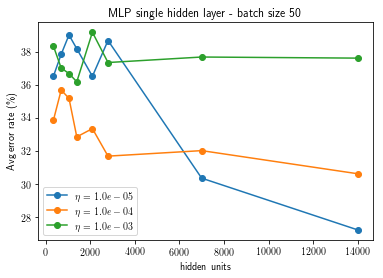

In [20]:
import numpy as np
import matplotlib.pyplot as plt
avg_err_rates = np.array([[36.5000, 33.8333, 38.3333], 
                 [37.8333, 35.6667, 37.0000],
                 [39.0000, 35.1667, 36.6667],
                 [38.1667, 32.8333, 36.1667],
                 [36.5000, 33.3333, 39.1667],
                 [38.6667, 31.6667, 37.3333],
                 [30.3333, 32.0000, 37.6667],
                 [27.2000, 30.6000, 37.6000]])  # average from 6 repetitions of above cell (5 for the 14000-unit MLP)
plt.rc('text', usetex=True)
plt.figure()
plt.title("MLP single hidden layer - batch size 50")
for i in range(0, len(eta_vals)):
    plt.plot(np.array(Nhidden_ratios)*dim, avg_err_rates[:, i], '-o', label="$\eta={:.1e}$".format(eta_vals[i]))
plt.xlabel('hidden units')
plt.ylabel('Avg error rate (\%)')
plt.legend()
plt.show()